# Text Analytics Coursework -- Data Loader

This notebook is to help get you started with the datasets used in the coursework assignment. 

For this coursework, we recommend that you use your virtual environment that you created for the labs. 

In [10]:
%load_ext autoreload
%autoreload 2

# Use HuggingFace's datasets library to access the Emotion dataset
from datasets import load_dataset
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Financial News Sentiment Classification

The Financial Phrasebank dataset contains sentences from financial news articles, classified into negative (0), neutral (1), or positive (2) sentiment. See [HuggingFace](https://huggingface.co/datasets/financial_phrasebank) for more information. 

First we need to load the data. We only have access to the original training data, so we will split this into our own validation and test sets. The _validation_ set (also called 'development' set or 'devset') can be used to compute performance of your model when tuning hyperparameters, optimising combinations of features, or looking at the errors your model makes before improving it. This allows you to hold out the test set (i.e., not to look at it at all when developing your method) to give a fair evaluation of the model and how well it generalises to new examples. This avoids tuning the model to specific examples in the test set. An alternative approach to validation is to not use a single fixed validation set, but instead use [cross validation](https://scikit-learn.org/stable/modules/cross_validation.html). 

In [12]:
from sklearn.model_selection import train_test_split

cache_dir = "./data_cache"

train_dataset = load_dataset(
    "financial_phrasebank",
    name="sentences_50agree",
    split="train",
    cache_dir=cache_dir,
)
print(f"Training dataset with {len(train_dataset)} instances loaded")

# Split the test set out
train_texts, test_texts, train_labels, test_labels = train_test_split(train_dataset["sentence"], train_dataset["label"], test_size=0.25)

# Optionally, split out a validation set
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.25)

print(f"Training dataset with {len(train_labels)} instances loaded")
print(f"Validation dataset with {len(val_labels)} instances loaded")
print(f"Test dataset with {len(test_labels)} instances loaded")


Training dataset with 4846 instances loaded
Training dataset with 2725 instances loaded
Validation dataset with 909 instances loaded
Test dataset with 1212 instances loaded


# 1.1) Non-neural method (Naive Bayes)

Training dataset with 4846 instances loaded
Training dataset with 2725 instances loaded
Validation dataset with 909 instances loaded
Test dataset with 1212 instances loaded
Validation Precision: 0.6806
Validation Recall: 0.6909
Validation Accuracy: 0.6909
Test Precision: 0.7373
Test Recall: 0.7434
Test Accuracy: 0.7434


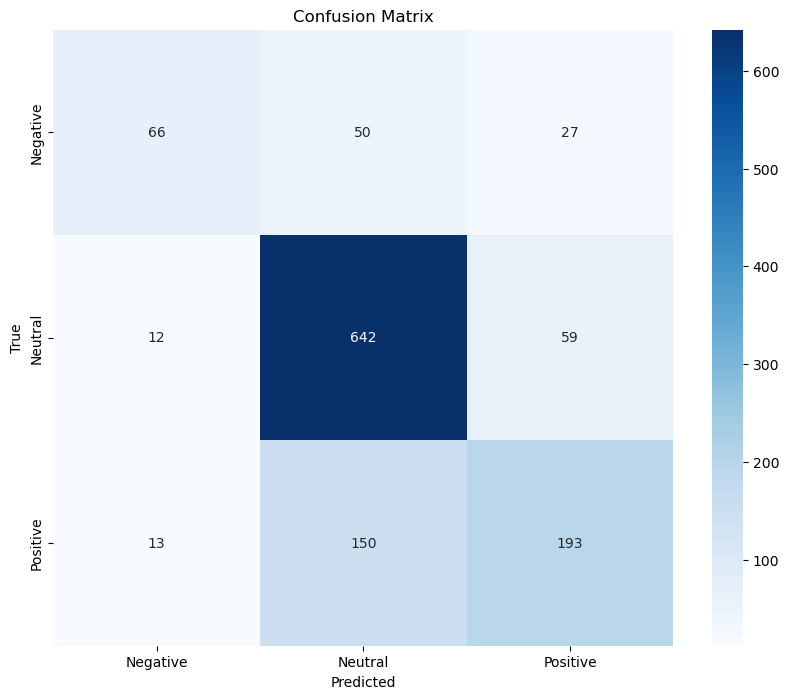

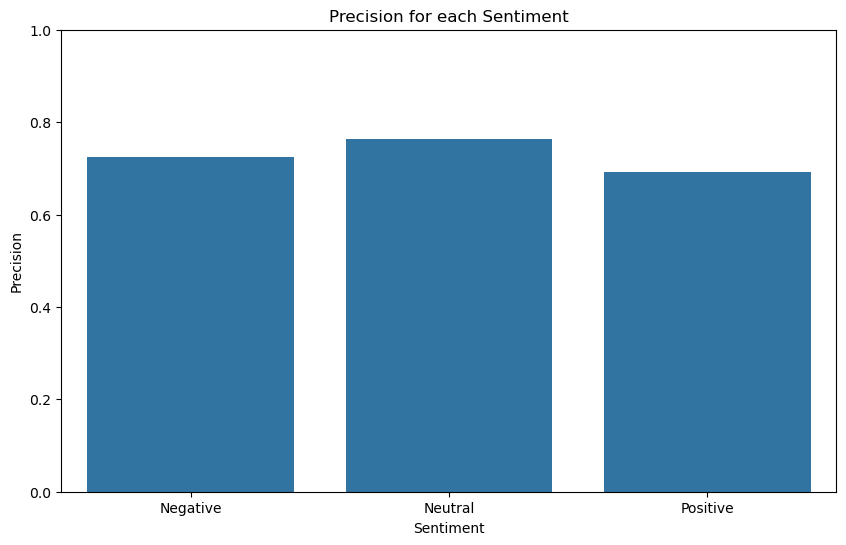

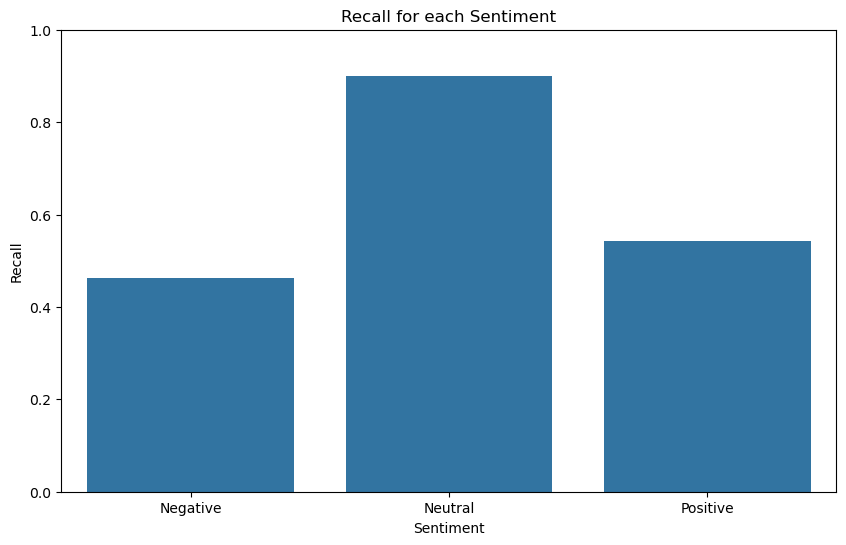

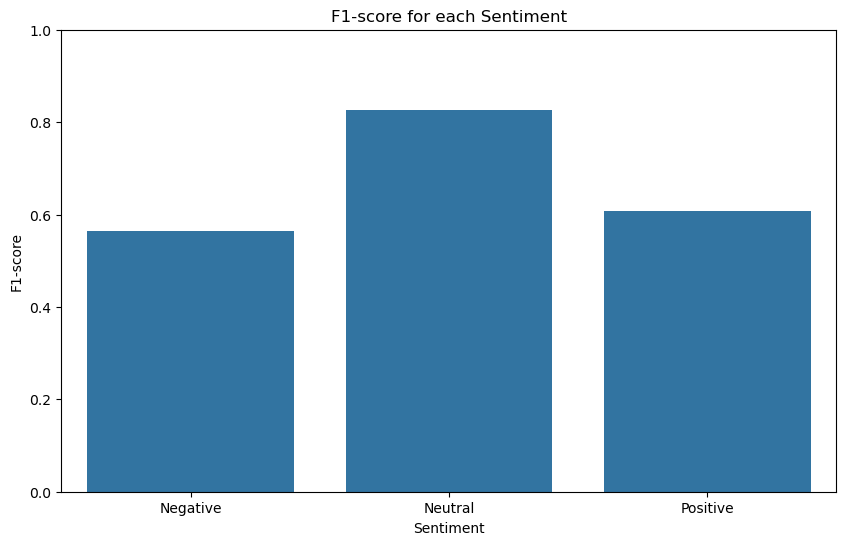

In [3]:
import re
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from sklearn.model_selection import train_test_split

# Step 1: Load the dataset
cache_dir = "./data_cache"

train_dataset = load_dataset(
    "financial_phrasebank",
    name="sentences_50agree",
    split="train",
    cache_dir=cache_dir,
)
print(f"Training dataset with {len(train_dataset)} instances loaded")

# Step 2: Split the dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(train_dataset["sentence"], train_dataset["label"], test_size=0.25, random_state=42)
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.25, random_state=42)

print(f"Training dataset with {len(train_labels)} instances loaded")
print(f"Validation dataset with {len(val_labels)} instances loaded")
print(f"Test dataset with {len(test_labels)} instances loaded")

# Step 3: Preprocess Texts
def preprocess_text(text):
    text = re.sub(r'RT @\w+: ', '', text)  # Remove retweets
    text = re.sub(r'@\w+', '', text)  # Remove handles
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove special characters and numbers
    text = text.lower().strip()  # Convert to lowercase and strip whitespace
    return text

train_texts = [preprocess_text(text) for text in train_texts]
val_texts = [preprocess_text(text) for text in val_texts]
test_texts = [preprocess_text(text) for text in test_texts]

# Step 4: Create DataFrames
train_df = pd.DataFrame({'text': train_texts, 'label': train_labels})
val_df = pd.DataFrame({'text': val_texts, 'label': val_labels})
test_df = pd.DataFrame({'text': test_texts, 'label': test_labels})

# Step 5: Feature Extraction and Naïve Bayes Classification
vectorizer = CountVectorizer()

X_train = vectorizer.fit_transform(train_df['text'])
X_val = vectorizer.transform(val_df['text'])
X_test = vectorizer.transform(test_df['text'])

nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, train_df['label'])

val_predictions = nb_classifier.predict(X_val)
test_predictions = nb_classifier.predict(X_test)

# Evaluate on the validation set
val_precision = precision_score(val_df['label'], val_predictions, average='weighted')
val_recall = recall_score(val_df['label'], val_predictions, average='weighted')
val_accuracy = accuracy_score(val_df['label'], val_predictions)

print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Evaluate on the test set
test_precision = precision_score(test_df['label'], test_predictions, average='weighted')
test_recall = recall_score(test_df['label'], test_predictions, average='weighted')
test_accuracy = accuracy_score(test_df['label'], test_predictions)

print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Step 6: Plot Confusion Matrix and Metrics
# Confusion Matrix
conf_matrix = confusion_matrix(test_df['label'], test_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
class_report = classification_report(test_df['label'], test_predictions, target_names=["Negative", "Neutral", "Positive"], output_dict=True)

# Precision, Recall, and F1-Score Bar Plots
metrics = ['precision', 'recall', 'f1-score']
labels = list(class_report.keys())[:-3]  # Exclude 'accuracy', 'macro avg', 'weighted avg'

for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=labels, y=[class_report[label][metric] for label in labels])
    plt.xlabel('Sentiment')
    plt.ylabel(metric.capitalize())
    plt.title(f'{metric.capitalize()} for each Sentiment')
    plt.ylim(0, 1)
    plt.show()


In [4]:
# Step 7: Display Example Results and Predictions
example_indices = np.random.choice(len(test_df), 10, replace=False)
for idx in example_indices:
    print(f"Text: {test_df.iloc[idx]['text']}")
    print(f"Actual Label: {train_dataset.features['label'].names[test_df.iloc[idx]['label']]}")
    print(f"Predicted Label: {train_dataset.features['label'].names[test_predictions[idx]]}")
    print("="*50)

Text: october   finnish wood products technology supplier raute oyj hel  rutav said today it swung to a net profit of eurm for the first nine months of  versus a net loss of eur  m for the same period a year earlier
Actual Label: positive
Predicted Label: positive
Text: currently  yit builds a housing estate zapadnye vorota  square metres in the city and a house  square metres  which will be completed at the end of
Actual Label: neutral
Predicted Label: neutral
Text: almost the entire office building will be occupied by metso
Actual Label: neutral
Predicted Label: neutral
Text: rinkuskiai s beer sales fell by  per cent to  million litres  while kauno alus  beer sales jumped by  per cent to  million litres
Actual Label: neutral
Predicted Label: positive
Text: sukhraj dulai  of the  block of boni sue court  a culdesac on the city s north side  started the vehicle and went inside his house about  am tuesday  leaving the garage door open
Actual Label: neutral
Predicted Label: neutral
Text:

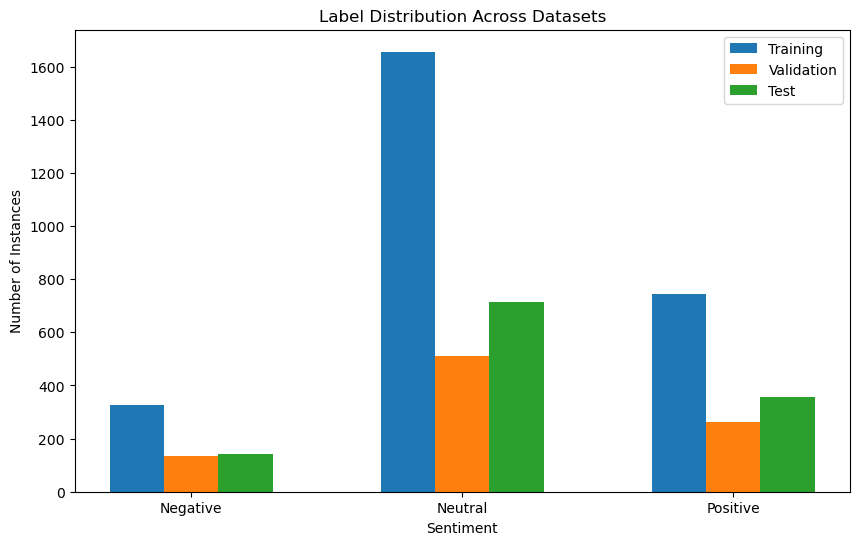

In [5]:
# Step 8: Plot Label Distribution
def plot_label_distribution(train_labels, val_labels, test_labels):
    # Compute label counts for all datasets
    train_counts = np.bincount(train_labels)
    val_counts = np.bincount(val_labels)
    test_counts = np.bincount(test_labels)

    # Set sentiment labels
    sentiments = ['Negative', 'Neutral', 'Positive']
    x = np.arange(len(sentiments))

    # Plot label distribution
    width = 0.2
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width, train_counts, width, label='Training')
    ax.bar(x, val_counts, width, label='Validation')
    ax.bar(x + width, test_counts, width, label='Test')

    ax.set_xlabel('Sentiment')
    ax.set_ylabel('Number of Instances')
    ax.set_title('Label Distribution Across Datasets')
    ax.set_xticks(x)
    ax.set_xticklabels(sentiments)
    ax.legend()

    plt.show()

# Plot label distribution for all datasets
plot_label_distribution(train_labels, val_labels, test_labels)

# 1.2) Neural network based method (BERT)

Dataset with 4846 instances loaded


C:\Users\krish\anaconda3\envs\text_analytics\Lib\site-packages\huggingface_hub-0.23.0-py3.8.egg\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cpu


C:\Users\krish\anaconda3\envs\text_analytics\Lib\site-packages\transformers\optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/1705 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6192, Train Accuracy = 0.7426, Val Loss = 0.3908, Val Accuracy = 0.8535
Epoch 2: Train Loss = 0.2838, Train Accuracy = 0.8937, Val Loss = 0.4148, Val Accuracy = 0.8349
Epoch 3: Train Loss = 0.1288, Train Accuracy = 0.9553, Val Loss = 0.4373, Val Accuracy = 0.8596
Epoch 4: Train Loss = 0.0567, Train Accuracy = 0.9813, Val Loss = 0.4890, Val Accuracy = 0.8498
Epoch 5: Train Loss = 0.0245, Train Accuracy = 0.9934, Val Loss = 0.5167, Val Accuracy = 0.8607


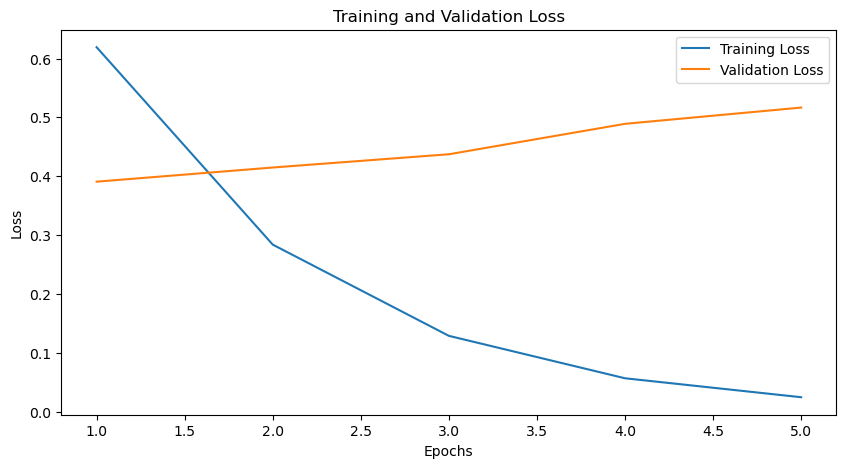

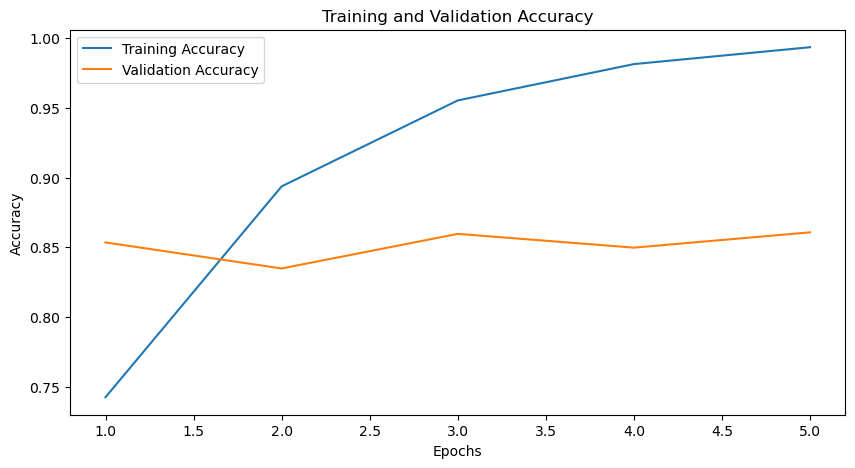

Test Loss: 0.5404, Test Accuracy: 0.8561


In [6]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_scheduler
from sklearn.model_selection import train_test_split
from datasets import load_dataset
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Load dataset
cache_dir = "./data_cache"
financial_phrasebank_dataset = load_dataset(
    "financial_phrasebank",
    name="sentences_50agree",
    split="train",
    cache_dir=cache_dir,
)
print(f"Dataset with {len(financial_phrasebank_dataset)} instances loaded")

# Split the dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(financial_phrasebank_dataset["sentence"], financial_phrasebank_dataset["label"], test_size=0.25)
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.25)

# Define number of labels
num_labels = len(set(financial_phrasebank_dataset["label"]))

# Load pre-trained BERT model and tokenizer
model_id = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_id)
model = BertForSequenceClassification.from_pretrained(model_id, num_labels=num_labels)

# Define custom Dataset class
class FinancialPhrasebankDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        inputs_encoded = self.tokenizer(self.texts[index], padding="max_length", max_length=128, truncation=True, return_tensors="pt")
        return {"input_ids": inputs_encoded["input_ids"].squeeze(), "labels": torch.tensor(self.labels[index], dtype=torch.long), "attention_mask": inputs_encoded["attention_mask"].squeeze()}

# Create DataLoader instances
train_dataset = FinancialPhrasebankDataset(train_texts, train_labels, tokenizer)
val_dataset = FinancialPhrasebankDataset(val_texts, val_labels, tokenizer)
test_dataset = FinancialPhrasebankDataset(test_texts, test_labels, tokenizer)

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=8)
val_dataloader = DataLoader(val_dataset, batch_size=8)
test_dataloader = DataLoader(test_dataset, batch_size=8)

# Set up optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 5
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# Set device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")
model = model.to(device)

# Initialize progress bar
progress_bar = tqdm(range(num_training_steps))

# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

def calculate_accuracy(preds, labels):
    return (preds == labels).sum().item() / labels.size(0)

for epoch in range(num_epochs):
    # Training
    model.train()
    epoch_train_loss = 0
    epoch_train_acc = 0
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        logits = outputs.logits
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        epoch_train_loss += loss.item()
        predictions = torch.argmax(logits, dim=-1)
        epoch_train_acc += calculate_accuracy(predictions, batch["labels"])
    train_losses.append(epoch_train_loss / len(train_dataloader))
    train_accuracies.append(epoch_train_acc / len(train_dataloader))

    # Validation
    model.eval()
    epoch_val_loss = 0
    epoch_val_acc = 0
    for batch in val_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
            loss = outputs.loss
            logits = outputs.logits
        epoch_val_loss += loss.item()
        predictions = torch.argmax(logits, dim=-1)
        epoch_val_acc += calculate_accuracy(predictions, batch["labels"])
    val_losses.append(epoch_val_loss / len(val_dataloader))
    val_accuracies.append(epoch_val_acc / len(val_dataloader))

    print(f"Epoch {epoch + 1}: Train Loss = {train_losses[-1]:.4f}, Train Accuracy = {train_accuracies[-1]:.4f}, Val Loss = {val_losses[-1]:.4f}, Val Accuracy = {val_accuracies[-1]:.4f}")

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.savefig("loss_plot.png")
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Training Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")
plt.savefig("accuracy_plot.png")
plt.show()

# Evaluate on test set
model.eval()
test_loss = 0
test_acc = 0
for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
        loss = outputs.loss
        logits = outputs.logits
    test_loss += loss.item()
    predictions = torch.argmax(logits, dim=-1)
    test_acc += calculate_accuracy(predictions, batch["labels"])
test_loss /= len(test_dataloader)
test_acc /= len(test_dataloader)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


# 1.3) Evaluation of both models

Test Precision (Naive Bayes): 0.7373
Test Recall (Naive Bayes): 0.7434
Test Accuracy (Naive Bayes): 0.7434


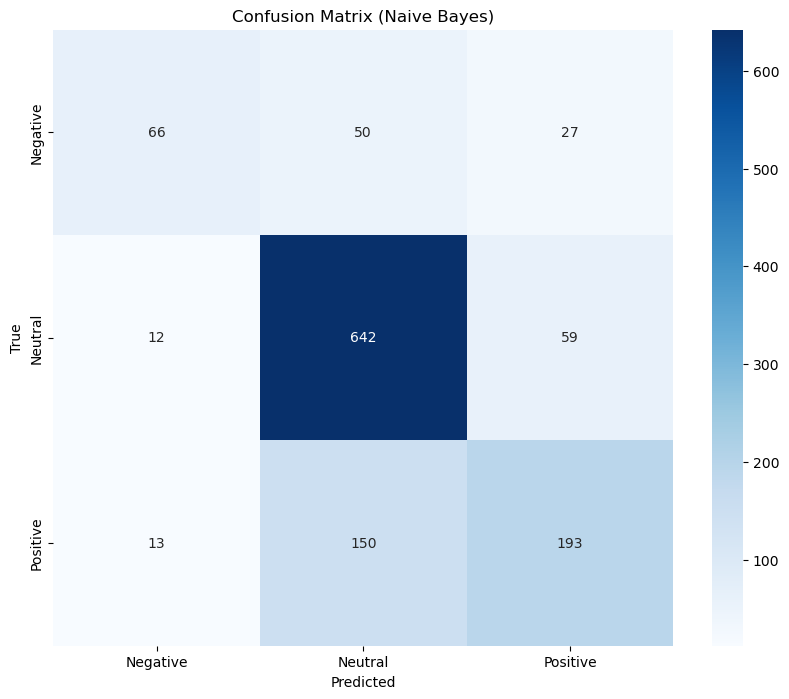

In [7]:
# Results for Naive Bayes Classifier
print(f"Test Precision (Naive Bayes): {test_precision:.4f}")
print(f"Test Recall (Naive Bayes): {test_recall:.4f}")
print(f"Test Accuracy (Naive Bayes): {test_accuracy:.4f}")

# Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Naive Bayes)')
plt.show()


Test Loss (BERT): 0.5404
Test Accuracy (BERT): 0.8561


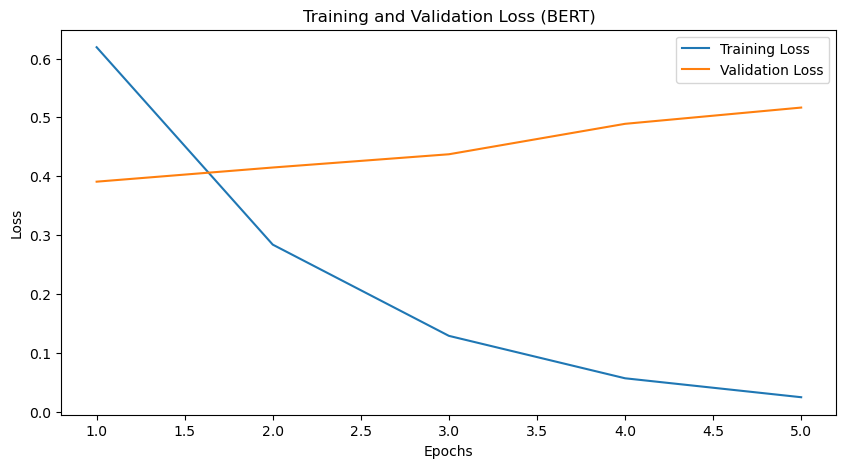

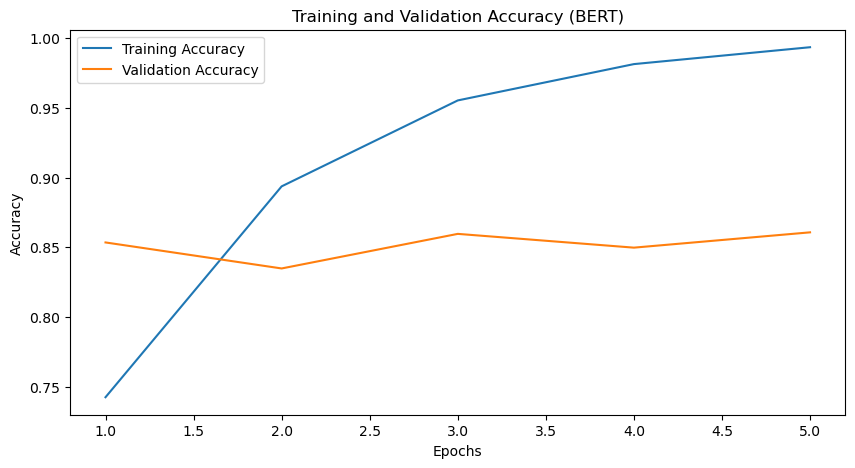

In [8]:
# Results for BERT Classifier
print(f"Test Loss (BERT): {test_loss:.4f}")
print(f"Test Accuracy (BERT): {test_acc:.4f}")

# Learning Curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss (BERT)")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Training Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy (BERT)")
plt.show()


In [13]:
# Misclassified Examples
misclassified_indices = [i for i, (pred, actual) in enumerate(zip(test_predictions, test_labels)) if pred != actual]

for idx in misclassified_indices[:5]:  # Displaying first 5 misclassified examples
    print(f"Text: {test_texts[idx]}")
    print(f"Actual Label: {train_dataset.features['label'].names[test_labels[idx]]}")
    print(f"Predicted Label: {train_dataset.features['label'].names[test_predictions[idx]]}")
    print("="*50)


Text: The floor area of the Yliopistonrinne project will be 7,900 sq m 85,030 sq ft and the building 's gross area will total 12,800 sq m. A total 25.1 % of the facilities have been let .
Actual Label: neutral
Predicted Label: positive
Text: Earnings per share ( EPS ) amounted to a loss of EUR0 .38 .
Actual Label: negative
Predicted Label: neutral
Text: Merrill Lynch analyst Campbell Morgan upgraded his recommendation on PaperlinX from `` neutral '' to `` buy '' in May .
Actual Label: positive
Predicted Label: neutral
Text: The liquidity providing was interrupted on May 11 , 2007 when Aspocomp Group Oyj 's shares traded below 0.50 cent ( Aspocomp 's stock exchange release 11.5.2007 ) .
Actual Label: negative
Predicted Label: positive
Text: The agreement was signed with Biohit Healthcare Ltd , the UK-based subsidiary of Biohit Oyj , a Finnish public company which develops , manufactures and markets liquid handling products and diagnostic test systems .
Actual Label: positive
Predicted L

# 1.4) Topic Identification (Latent Dirichlet Allocation)

In [14]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from datasets import load_dataset

# Preprocess Text Function
def preprocess_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = text.lower().strip()
    return text

# Tokenize and Lemmatize Function
def tokenize_and_lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stopwords.words('english')]
    return tokens

# Load and preprocess dataset
cache_dir = "./data_cache"
financial_phrasebank_dataset = load_dataset(
    "financial_phrasebank",
    name="sentences_50agree",
    split="train",
    cache_dir=cache_dir,
)
data = pd.DataFrame(financial_phrasebank_dataset)
data['cleaned_text'] = data['sentence'].apply(preprocess_text)
data['tokens'] = data['cleaned_text'].apply(tokenize_and_lemmatize)
data['cleaned_text_str'] = data['tokens'].apply(lambda x: ' '.join(x))

# Vectorize the combined dataset
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
all_texts = data['cleaned_text_str']
all_vectors = vectorizer.fit_transform(all_texts)

# Separate by sentiment
negative_vectors = all_vectors[data['label'] == 0]
neutral_vectors = all_vectors[data['label'] == 1]
positive_vectors = all_vectors[data['label'] == 2]

# Apply LDA
num_topics = 5
lda_negative = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_neutral = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_positive = LatentDirichletAllocation(n_components=num_topics, random_state=42)

lda_negative.fit(negative_vectors)
lda_neutral.fit(neutral_vectors)
lda_positive.fit(positive_vectors)

# Function to display topics
def display_topics(model, feature_names, num_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        topic_words = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
        topics.append(topic_words)
    return topics

# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Display topics
num_top_words = 10
negative_topics = display_topics(lda_negative, feature_names, num_top_words)
neutral_topics = display_topics(lda_neutral, feature_names, num_top_words)
positive_topics = display_topics(lda_positive, feature_names, num_top_words)

print("Negative Sentiment Topics:")
for i, topic in enumerate(negative_topics):
    print(f"Topic {i + 1}: {', '.join(topic)}")

print("\nNeutral Sentiment Topics:")
for i, topic in enumerate(neutral_topics):
    print(f"Topic {i + 1}: {', '.join(topic)}")

print("\nPositive Sentiment Topics:")
for i, topic in enumerate(positive_topics):
    print(f"Topic {i + 1}: {', '.join(topic)}")


Negative Sentiment Topics:
Topic 1: item, nonrecurring, excluding, pretax, share, operation, market, company, percent, helsinki
Topic 2: eur, mn, profit, operating, net, period, quarter, sale, loss, compared
Topic 3: company, million, said, today, oyj, hel, finnish, result, usd, maker
Topic 4: share, pct, helsinki, omx, finland, finnish, personnel, earnings, eps, lower
Topic 5: mln, euro, million, said, finnish, month, net, oyj, sale, profit

Neutral Sentiment Topics:
Topic 1: company, said, finland, new, service, business, market, order, product, line
Topic 2: market, mobile, finland, service, nokia, bank, company, new, device, customer
Topic 3: company, business, said, service, finnish, building, plant, construction, oyj, production
Topic 4: share, company, group, helsinki, corporation, capital, stock, finland, right, option
Topic 5: eur, million, sale, net, company, euro, mn, mln, value, total

Positive Sentiment Topics:
Topic 1: company, said, new, order, service, technology, busin

# MIT Restaurants

This dataset consists of requests for restaurant recommendations given by users of a dialogue system. They are tagged with named entities in eight categories:
{
    "O": 0,
    "B-Rating": 1,
    "I-Rating": 2,
    "B-Amenity": 3,
    "I-Amenity": 4,
    "B-Location": 5,
    "I-Location": 6,
    "B-Restaurant_Name": 7,
    "I-Restaurant_Name": 8,
    "B-Price": 9,
    "B-Hours": 10,
    "I-Hours": 11,
    "B-Dish": 12,
    "I-Dish": 13,
    "B-Cuisine": 14,
    "I-Price": 15,
    "I-Cuisine": 16
}
For further details, see [the HuggingFace page](https://huggingface.co/datasets/tner/mit_restaurant).

In [15]:
ner_dataset = load_dataset(
    "tner/mit_restaurant", 
)

print(f'The dataset is a dictionary with {len(ner_dataset)} splits: \n\n{ner_dataset}')

The dataset is a dictionary with 3 splits: 

DatasetDict({
    train: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 6900
    })
    validation: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 760
    })
    test: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 1521
    })
})


In [16]:
# It  may be useful to obtain the data in a list format for some sequence tagging methods
train_sentences_ner = [item['tokens'] for item in ner_dataset['train']]
train_labels_ner = [[str(tag) for tag in item['tags']] for item in ner_dataset['train']]

val_sentences_ner = [item['tokens'] for item in ner_dataset['validation']]
val_labels_ner = [[str(tag) for tag in item['tags']] for item in ner_dataset['validation']]

test_sentences_ner = [item['tokens'] for item in ner_dataset['test']]
test_labels_ner = [[str(tag) for tag in item['tags']] for item in ner_dataset['test']]

In [17]:
# Show the different tag values in the dataset:
np.unique(np.concatenate(train_labels_ner))

array(['0', '1', '10', '11', '12', '13', '14', '15', '16', '2', '3', '4',
       '5', '6', '7', '8', '9'], dtype='<U2')

### (Optional) Transformer Sequence Tagger

People that want to use a transformer for task 2 may want to take a look at the [Token Classification tutorial](https://colab.research.google.com/github/huggingface/notebooks/blob/master/examples/token_classification.ipynb#scrollTo=vc0BSBLIIrJQ) from HuggingFace. There is no requirement to use a transformer to achieve high marks, this is one option that you may consider. Feel free to skip this part of the notebook if you are using a different kind of model that does not require it.

A useful function provided by HuggingFace as part of the Token Classification page is tokenize_and_align. You can reuse this function if you are working with a method that tokenizes the text in a diferent way to the NER dataset. This function is provided below:

In [18]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, max_length=128, is_split_into_words=True)
    print(tokenized_inputs.keys())
    labels = []
    for i, label in enumerate(examples["tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [19]:
from transformers import AutoTokenizer

# An example of how to use tokenize_and_align:
tokenizer = AutoTokenizer.from_pretrained("huawei-noah/TinyBERT_General_4L_312D") 
label_all_tokens=False

tokenized_dataset = ner_dataset.map(tokenize_and_align_labels, batched=True)

C:\Users\krish\anaconda3\envs\text_analytics\Lib\site-packages\huggingface_hub-0.23.0-py3.8.egg\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.


Map:   0%|          | 0/1521 [00:00<?, ? examples/s]

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


# 2.1) Sequence Tagger using BERT

In [20]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer, DataCollatorForTokenClassification
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

# Load the pre-trained model
model = AutoModelForTokenClassification.from_pretrained("huawei-noah/TinyBERT_General_4L_312D", num_labels=17)

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)

# Define the data collator
data_collator = DataCollatorForTokenClassification(tokenizer)

from sklearn.preprocessing import MultiLabelBinarizer

# Metrics function
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Convert predictions and labels to lists of lists
    true_labels = [[label for label in label_set if label != -100] for label_set in labels]
    true_predictions = [
        [p for (p, l) in zip(prediction, label_set) if l != -100]
        for prediction, label_set in zip(predictions, labels)
    ]

    # Flatten the lists
    true_labels = [item for sublist in true_labels for item in sublist]
    true_predictions = [item for sublist in true_predictions for item in sublist]

    # Calculate precision, recall, and f1 score
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, true_predictions, average="macro")

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Evaluate the model
results = trainer.evaluate(tokenized_dataset["test"])
print(results)


Some weights of BertForTokenClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.776022,0.511468,0.485000,0.470701
2,1.071400,0.620861,0.631240,0.588584,0.574234
3,0.675300,0.585538,0.639624,0.607283,0.597081


C:\Users\krish\anaconda3\envs\text_analytics\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\krish\anaconda3\envs\text_analytics\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\krish\anaconda3\envs\text_analytics\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

{'eval_loss': 0.5807748436927795, 'eval_precision': 0.7248037131044525, 'eval_recall': 0.6218642678771072, 'eval_f1': 0.6221902996298458, 'eval_runtime': 3.3454, 'eval_samples_per_second': 454.654, 'eval_steps_per_second': 28.696, 'epoch': 3.0}


C:\Users\krish\anaconda3\envs\text_analytics\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# 2.2) Evaluation of sequence tagger

In [21]:
predictions, labels, _ = trainer.predict(tokenized_dataset["test"])
predictions = np.argmax(predictions, axis=2)

# Convert predictions and labels to lists of lists
true_labels = [[label for label in label_set if label != -100] for label_set in labels]
true_predictions = [
    [p for (p, l) in zip(prediction, label_set) if l != -100]
    for prediction, label_set in zip(predictions, labels)
]

# Identify mislabelled examples
mislabelled_examples = []
for i in range(len(true_labels)):
    if true_labels[i] != true_predictions[i]:
        mislabelled_examples.append((test_sentences_ner[i], true_labels[i], true_predictions[i]))

# Display a few mislabelled examples
for example in mislabelled_examples[:5]:
    print("Sentence:", " ".join(example[0]))
    print("True Labels:", example[1])
    print("Predicted Labels:", example[2])
    print("\n")


C:\Users\krish\anaconda3\envs\text_analytics\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Sentence: a four star restaurant with a bar
True Labels: [0, 1, 2, 0, 5, 6, 3]
Predicted Labels: [0, 1, 2, 0, 0, 0, 3]


Sentence: any bbq places open before 5 nearby
True Labels: [0, 14, 0, 10, 11, 11, 5]
Predicted Labels: [0, 14, 0, 10, 11, 6, 5]


Sentence: any dancing establishments with reasonable pricing
True Labels: [0, 5, 6, 0, 9, 0]
Predicted Labels: [0, 3, 0, 0, 9, 0]


Sentence: any good cheap german restaurants nearby
True Labels: [0, 0, 9, 14, 0, 5]
Predicted Labels: [0, 1, 9, 14, 0, 5]


Sentence: any good ice cream parlors around
True Labels: [0, 1, 14, 16, 16, 5]
Predicted Labels: [0, 1, 12, 8, 8, 5]




C:\Users\krish\anaconda3\envs\text_analytics\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


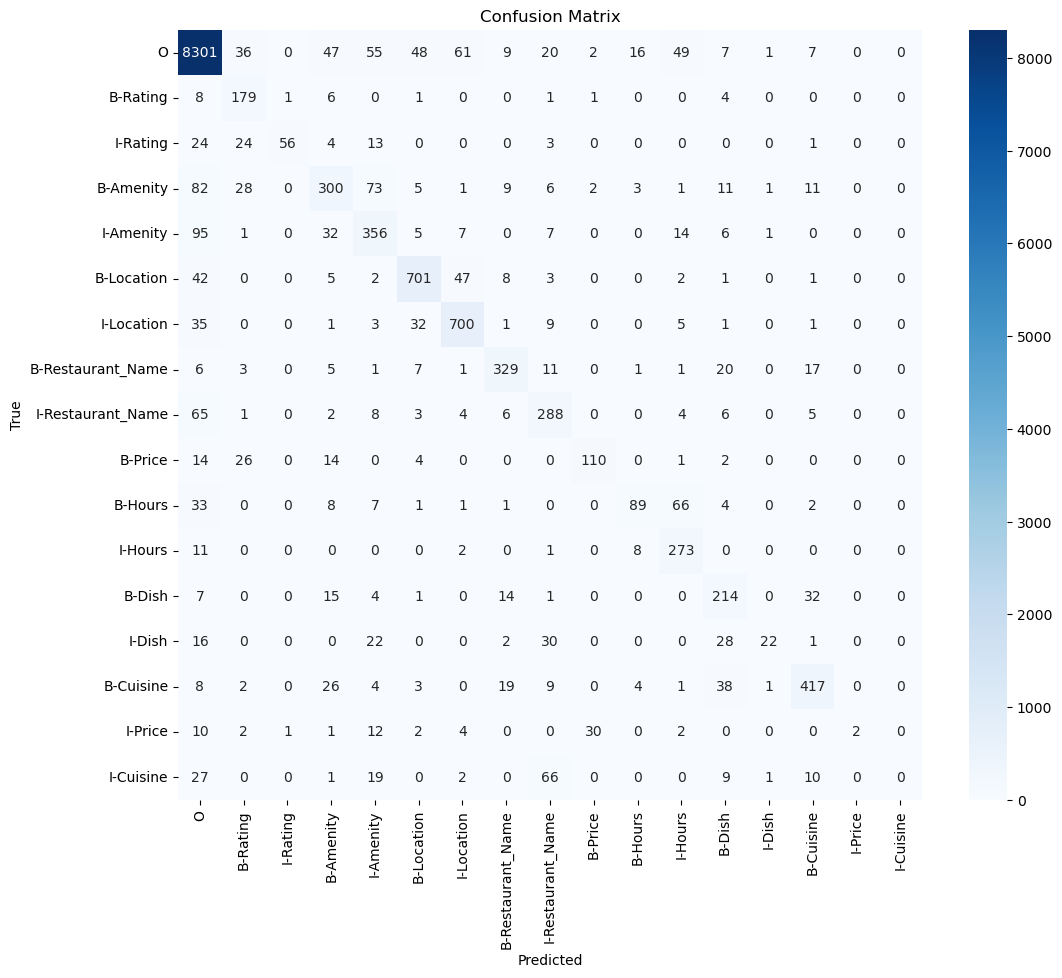

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define label names
label_names = [
    "O", "B-Rating", "I-Rating", "B-Amenity", "I-Amenity", "B-Location", "I-Location", 
    "B-Restaurant_Name", "I-Restaurant_Name", "B-Price", "B-Hours", "I-Hours", 
    "B-Dish", "I-Dish", "B-Cuisine", "I-Price", "I-Cuisine"
]

# Get predictions on test set
predictions, labels, _ = trainer.predict(tokenized_dataset["test"])
predictions = np.argmax(predictions, axis=2)

# Convert predictions and labels to lists of lists
true_labels = [[label for label in label_set if label != -100] for label_set in labels]
true_predictions = [
    [p for (p, l) in zip(prediction, label_set) if l != -100]
    for prediction, label_set in zip(predictions, labels)
]

# Flatten the lists
flat_true_labels = [item for sublist in true_labels for item in sublist]
flat_predictions = [item for sublist in true_predictions for item in sublist]

# Generate confusion matrix
cm = confusion_matrix(flat_true_labels, flat_predictions, labels=range(len(label_names)))

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# 2.3) Similarity analysis between dishes

In [23]:
%pip install spacy
%pip install transformers


Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\users\krish\anaconda3\envs\text_analytics\lib\site-packages\huggingface_hub-0.23.0-py3.8.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\users\krish\anaconda3\envs\text_analytics\lib\site-packages\huggingface_hub-0.23.0-py3.8.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [24]:
import spacy.cli
spacy.cli.download("en_core_web_md")


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [27]:
import spacy
from transformers import BertTokenizer, BertModel
import torch
from sklearn.metrics.pairwise import cosine_similarity

# Load pre-trained SpaCy model
nlp = spacy.load('en_core_web_md')

# Define the query
query = "sushi"

# Convert query to SpaCy document
query_doc = nlp(query)

# Assume we have a list of all dishes/cuisines from the dataset
all_entities = ["sushi", "pizza", "burger", "taco", "ramen", "salad", "steak", "pasta", "ice cream", "soup"]

# Calculate similarities using SpaCy
similarities_spacy = []
for entity in all_entities:
    entity_doc = nlp(entity)
    similarity = query_doc.similarity(entity_doc)
    similarities_spacy.append((entity, similarity))

# Sort by similarity
similarities_spacy.sort(key=lambda x: x[1], reverse=True)

# Find top 5 similar and dissimilar entities
similar_spacy = similarities_spacy[:5]
dissimilar_spacy = similarities_spacy[-5:]

print("SpaCy Similar Entities to 'sushi':")
for entity, similarity in similar_spacy:
    print(f"{entity}: {similarity}")

print("\nSpaCy Dissimilar Entities to 'sushi':")
for entity, similarity in dissimilar_spacy:
    print(f"{entity}: {similarity}")

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to get the BERT embedding for a word
def get_bert_embedding(word):
    inputs = tokenizer(word, return_tensors="pt")
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

# Get BERT embedding for the query
query_embedding = get_bert_embedding(query)

# Calculate similarities using BERT
similarities_bert = []
for entity in all_entities:
    entity_embedding = get_bert_embedding(entity)
    similarity = cosine_similarity(query_embedding, entity_embedding)[0][0]
    similarities_bert.append((entity, similarity))

# Sort by similarity
similarities_bert.sort(key=lambda x: x[1], reverse=True)

# Find top 5 similar and dissimilar entities
similar_bert = similarities_bert[:5]
dissimilar_bert = similarities_bert[-5:]

print("\nBERT Similar Entities to 'sushi':")
for entity, similarity in similar_bert:
    print(f"{entity}: {similarity}")

print("\nBERT Dissimilar Entities to 'sushi':")
for entity, similarity in dissimilar_bert:
    print(f"{entity}: {similarity}")


SpaCy Similar Entities to 'sushi':
sushi: 1.0
ramen: 0.9999999953754505
burger: 0.6706848874484871
taco: 0.6706848874484871
pizza: 0.6542218973391833

SpaCy Dissimilar Entities to 'sushi':
steak: 0.6117058397586106
salad: 0.5999001623127584
pasta: 0.5695815475188395
soup: 0.5529016109336934
ice cream: 0.24579292328183122


C:\Users\krish\anaconda3\envs\text_analytics\Lib\site-packages\huggingface_hub-0.23.0-py3.8.egg\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



BERT Similar Entities to 'sushi':
sushi: 0.9999998807907104
ice cream: 0.7128573656082153
salad: 0.7087900638580322
pizza: 0.7071022987365723
steak: 0.698563277721405

BERT Dissimilar Entities to 'sushi':
burger: 0.6920221447944641
taco: 0.6836510896682739
pasta: 0.6592622399330139
ramen: 0.6585543751716614
soup: 0.6319062113761902
